# SMIB system as in Milano's book example 8.1 (AVR added)

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt
import ipywidgets

In [3]:
from core.smib_milano_ex8p1_4ord_avr import smib_milano_ex8p1_4ord_avr_class,daesolver

In [4]:
syst = smib_milano_ex8p1_4ord_avr_class()
syst.t_end = 15.0
syst.Dt = 0.005
syst.decimation =10
syst.update()

In [5]:
def test(syst,p_m,v_ref,K_a,use_numba=True):
    # simulation parameters
    syst.struct[0].imax = 50    # maximum number of iterations
    syst.struct[0].itol = 1e-6  # relative tolerance to stop iteration
    syst.struct[0].solvern = 5  # 5 = DAE trapezoidal solver (fixed step)
    syst.struct[0].it = 0       # set time step to zero
    syst.struct[0].it_store = 0 # set storage to zero
    syst.struct[0].t = 0.0      # set time to zero
    
    syst.struct[0].D = 0
    
    syst.struct[0].p_m = 0
    syst.struct[0].v_ref = 1
    syst.struct[0].T_r = 0.02
    syst.struct[0].K_a = K_a
    
    syst.struct[0].T1d0 = 8

    syst.struct.P_t = 0
    syst.struct.Q_t = 0    
    
    # compute initial conditions using x and y_ini 
    xy0 = np.ones(syst.N_x+syst.N_y)
    xy = sopt.fsolve(syst.ini_problem,xy0 )

    # from ini system to run system
    syst.struct[0].p_m = xy[syst.xy_ini_list.index('p_m')]
    syst.struct[0].v_ref = xy[syst.xy_ini_list.index('v_ref')]

    syst.struct[0].x[:,0] = xy[0:syst.N_x]
    syst.struct[0].y[:,0] = xy[syst.N_x:]

    syst.struct[0].y[syst.y_list.index('P_t'),0] = syst.struct.P_t
    syst.struct[0].y[syst.y_list.index('Q_t'),0] = syst.struct.Q_t
    
    # solve system
    syst.struct.t_end = 1.0  
    daesolver(syst.struct)    # run until 1 s
    syst.struct[0].p_m = p_m  # apply step in mechanical power p_m
    syst.struct[0].v_ref = v_ref  # apply step in mechanical power p_m
    syst.struct.t_end = 20.0  
    daesolver(syst.struct)    # run until 10 s
        
    T = syst.struct[0]['T'][:syst.struct[0].it_store]
    X = syst.struct[0]['X'][:syst.struct[0].it_store,:]
    Y = syst.struct[0]['Y'][:syst.struct[0].it_store,:]

    return T,X,Y

In [6]:
T,X,Y =test(syst,0.0,1.0,200,use_numba=True)


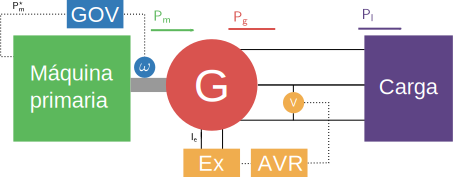

In [28]:
from IPython.display import SVG
SVG('./figures/esquema_avr_gov_sm_carga.svg')

In [29]:
plt.ioff()
plt.clf()

T,X,Y =test(syst,0.0,1.0,200,use_numba=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 4), frameon=False)
fig.canvas.toolbar_visible = False

line_delta = axes[0,0].plot(T, X[:,syst.x_list.index('delta')], label='$\sf \delta$')
line_omega = axes[1,0].plot(T, X[:,syst.x_list.index('omega')], label='$\sf \omega$')
line_v_1 = axes[0,1].plot(T, Y[:,syst.y_list.index('v_1')], label='$\sf v_1$')
#line_theta_1 = axes[0,1].plot(T, Y[:,syst.y_list.index('theta_1')], label='$\sf \\theta_1$')
line_p_t = axes[1,1].plot(T, Y[:,syst.y_list.index('P_t')], label='$\sf P_t$')
line_q_t = axes[1,1].plot(T, Y[:,syst.y_list.index('Q_t')], label='$\sf Q_t$')

x_0 = X[0,:]
y_0 = Y[0,:]

y_labels = ['$\delta$','$\omega$','$P_t$']

axes[0,0].set_ylim((-1,2))
axes[1,0].set_ylim((0.95,1.05))
axes[0,1].set_ylim((0.8,1.2))
axes[1,1].set_ylim((-0.5,1.5))

axes[0,0].grid(True)
axes[1,0].grid(True)
axes[0,1].grid(True)
axes[1,1].grid(True)
axes[0,0].legend(loc='best')
axes[1,0].legend(loc='best')
axes[0,1].legend(loc='best')
axes[1,1].legend(loc='best')

axes[1,0].set_xlabel('Time (s)')  
axes[1,1].set_xlabel('Time (s)') 

fig.tight_layout()
#axes[0].set_title('Par en función de la velocidad')
#axes[1].set_title('Corriente en función de la velocidad')


sld_p_m = ipywidgets.FloatSlider(orientation='horizontal',description = u"p\N{LATIN SUBSCRIPT SMALL LETTER M}:", 
                                value=0.0, min=0.0,max= 1.2, 
                                step=.1)


sld_v_ref = ipywidgets.FloatSlider(orientation='horizontal',description = u"v⭑", 
                                value=syst.struct.v_ref, min=0.9,max= 1.1, 
                                step=.01)

sld_K_a = ipywidgets.FloatSlider(orientation='horizontal',description =  'K\N{LATIN SUBSCRIPT SMALL LETTER A}' , 
                                value=syst.struct.K_a, min=0.0,max= 500, 
                                step=10)

prog_c = ipywidgets.IntProgress(
    value=100,
    min=0,
    max=120,
    step=1,
    description='SM Load:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal' 
)

prog_damp = ipywidgets.IntProgress(
    value=10,
    min=0,
    max=20,
    step=1,
    description='ζ = 1.0',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal' 
)

In [30]:
 

def update(change):
    
    p_m = sld_p_m.value
    v_ref = sld_v_ref.value
    K_a = sld_K_a.value
    
    try:
        T,X,Y = test(syst,p_m,v_ref,K_a,use_numba=True)

        line_delta[0].set_data(T, X[:,syst.x_list.index('delta')])
        line_omega[0].set_data(T, X[:,syst.x_list.index('omega')])
        line_v_1[0].set_data(T, Y[:,syst.y_list.index('v_1')])
        #line_theta_1[0].set_data(T, Y[:,syst.y_list.index('theta_1')])
        line_p_t[0].set_data(T, Y[:,syst.y_list.index('P_t')])
        line_q_t[0].set_data(T, Y[:,syst.y_list.index('Q_t')])

        c = np.abs(Y[-1,syst.y_list.index('i_d')]+1j*Y[-1,syst.y_list.index('i_q')])

        prog_c.bar_style = 'success'
        if c>0.9:
            prog_c.bar_style = 'warning'
        if c>1.0:
            prog_c.bar_style = 'danger'
        prog_c.value = 100*c
        
        A = syst.eval_A()

        w,v = np.linalg.eig(A)
        w_osc = w[w.imag>1.0]
        damp_psc = -w_osc.real/np.abs(w_osc)
        min_damp = np.min(damp_psc)

        prog_damp.bar_style = 'success'
        if min_damp<0.07:
            prog_damp.bar_style = 'warning'
        if min_damp<0.05:
            prog_damp.bar_style = 'danger'
        prog_damp.value = 100*min_damp
        min_damp_100 = 100*min_damp
        if min_damp_100>20: min_damp_100=20 
        if min_damp_100<0: min_damp_100=0
        prog_damp.description=f'ζ = {100*min_damp:2.0f}%'

        fig.canvas.draw_idle()
    except:
          print("An exception occurred")        
   
    
sld_p_m.observe(update, names='value')
sld_v_ref.observe(update, names='value')
sld_K_a.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_p_m,sld_v_ref,prog_c])
layout_row3 = ipywidgets.HBox([sld_K_a,prog_damp])

layout = ipywidgets.VBox([layout_row1,layout_row2,layout_row3])
layout
